In [3]:
import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import pdb

In [4]:
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
PowerTheta = np.array([38.29018572, 37.65306039, 38.00855419, 38.73256273, 39.36926748,
       39.86405353, 40.22086124, 40.44589774, 40.54870484, 40.55045989,
       40.70095953, 41.46173063, 43.25248543, 45.98926726, 49.29566467,
       52.83556305, 56.52346982, 60.36269157, 64.3524202 , 68.47769359,
       72.71945054, 76.89905869, 80.51516399, 83.03401433, 84.15904199,
       83.89240735, 82.26844207, 79.52729184, 76.07251473, 72.2958952 ,
       68.45430718, 64.73791746, 61.30609504, 58.17345317, 55.31154583,
       52.7660452 , 50.79182992, 49.67498941, 49.26046062, 48.6334227 ,
       46.83642493, 43.77355919, 40.27918283, 37.20522713, 35.04525891,
       34.04924416, 34.40661727, 35.92368012])
GasTheta = np.array([2.81145084, 2.76304781, 2.75516369, 2.76012114, 2.75811   ,
       2.74807589, 2.73185041, 2.71914404, 2.7312581 , 2.78949875,
       2.89661167, 3.03815321, 3.1995049 , 3.37083627, 3.54509695,
       3.71581731, 3.87964756, 4.03434353, 4.17888279, 4.31633758,
       4.45059611, 4.57966876, 4.68967835, 4.76550224, 4.79886395,
       4.79010961, 4.74061195, 4.65922203, 4.56072849, 4.45868332,
       4.35503145, 4.24597864, 4.12896081, 4.00748103, 3.88685281,
       3.77417548, 3.68158763, 3.6219074 , 3.59146408, 3.55818958,
       3.4882443 , 3.37526588, 3.24256103, 3.11387685, 3.0000309 ,
       2.9030518 , 2.82676425, 2.78845998])

In [5]:
PowerTheta.shape
Power.shape

(12,)

Power Price Fit:  [35.79215575878403, 37.485770716669755, 39.03959350074171, 40.48171317969971, 46.458177274891334, 62.002727856161066, 73.09798867405098, 75.02090467836038, 70.7747117615879, 63.59020925634578, 60.11922507527186, 48.04316644651519] 

CC Price Fit:  [35.79215575878403, 37.485770716669755, 39.03959350074171, 40.48171317969971, 46.458177274891334, 61.99559655325027, 73.09633722166971, 75.0206975233997, 70.77468654526464, 63.59020754721095, 56.09969360263553, 47.95697804036343] 

JC_Price_Fit:  [0.0, 0.0, 25.520833333333343, 2.9550309043852896, 0.34215997306274476, 0.03961834950441989, 0.004587367725699854, 0.0005311665658470942, 6.150322745943646e-05, 7.12139511622815e-06, 14.887153602356754, 1.7237681230352317] 

real Power Price:  [36.63 38.26 39.39 40.56 43.23 56.54 72.7  84.19 76.06 61.32 50.75 46.9 ] 

Gas_Price_Fit:  [3.0036447322987567, 2.9653610059058457, 2.918128357913426, 2.9135882751578777, 3.1006925003707924, 3.4096395688439416, 3.731476063929805, 3.9499161981

(38.36664498739274, 3.8801317267602937)

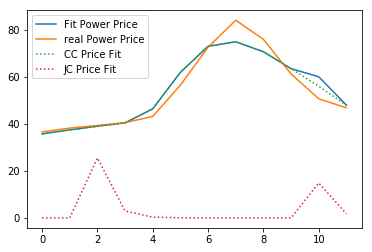

In [6]:
def meanReversion(random_seed , 
                  PowerPrices,
                  GasPrices,
                  PowerTheta,
                  GasTheta,
                  rho = 0.3,
                  T = 1):
    
    
    # N: number of intervals
    # n: number of paths
    # T: maturity
    # dt: interval of each path
    
    n = 100
    #np.random.seed(random_seed)
    dt = 1/48 
    N = int(np.floor(T/dt))
    
    #params
    alphaCC = 7
    alphaJC = 20
    alphaG = 3
    m = 75
    p = 0.083# lambda*dt, weekly probability
    CC0 = 35
    JC0 = 0 
    G0 = 3
    spike_thres = 75
    sigmaG = 7.22/np.sqrt(dt)/100
    
    #V summer and winter
    v_summer = 28.87/np.sqrt(dt)/100
    v_winter = 10.83/np.sqrt(dt)/100
    V = np.zeros((N+1,n))
    
    #
    W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    #
    CC = np.zeros((N+1,n)) 
    CC[0,:] = CC0
    
    JC = np.zeros((N+1,n))
    JC[0,:] = JC0
    
    G = np.zeros((N+1,n)) 
    G[0,:] = G0
    
    PC = np.zeros((N+1,n))
    PC[0,:] = CC[0,:]
    # 
    Power_MSE = 0
    Gas_MSE = 0
    #
    Power_Price_Fit = list()
    Gas_Price_Fit = list()
    CC_Price_Fit = list()
    JC_Price_Fit = list()
    
    
    for i in range(1,N+1):
        month = np.ceil(i/4)%12 
        month = int((month == 0)*12 + (month != 0)*month)
        monthIndicator = (month > 4)&(month < 9)
        V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
        CC[i,:] = alphaCC*(PowerTheta[(i-1)%48] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
        JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
        #Power Price
        PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:]>spike_thres)
        #Gas Price
        G[i,:]  = alphaG*(GasTheta[(i-1)%48] - G[i-1,:])*dt + sigmaG*G[i-1,:]*B[i,:]+G[i-1,:]
        if (i-1)%4 == 0:
            Power_MSE += np.abs(np.mean(PC[i,:]) - PowerPrices[month - 1])
            Gas_MSE += np.abs(np.mean(G[i,:]) - GasPrices[month - 1])
            Power_Price_Fit.append(np.mean(PC[i,:]))
            Gas_Price_Fit.append(np.mean(G[i,:]))
            CC_Price_Fit.append(np.mean(CC[i,:]))
            JC_Price_Fit.append(np.mean(JC[i,:]))
     

    
    fig = plt.figure()
    plt.plot(Power_Price_Fit,label = 'Fit Power Price')
    plt.plot(PowerPrices,label = 'real Power Price')
    plt.plot(CC_Price_Fit,label = 'CC Price Fit',linestyle = "dotted")
    plt.plot(JC_Price_Fit,label = 'JC Price Fit',linestyle = "dotted")
    
    plt.legend()
    
    print('Power Price Fit: ',Power_Price_Fit,'\n')
    print('CC Price Fit: ',CC_Price_Fit,'\n')
    print('JC_Price_Fit: ',JC_Price_Fit,'\n')
    print('real Power Price: ', PowerPrices,'\n')
    print('Gas_Price_Fit: ',Gas_Price_Fit,'\n')
    print('Gas Prices: ',GasPrices,'\n')
    return Power_MSE,Gas_MSE

meanReversion(12,Power,Gas,PowerTheta,GasTheta )

0

In [36]:
v_summer = 28.87/np.sqrt(dt)
v_winter = 10.83/np.sqrt(dt)
print(v_summer)
print(v_winter)

200.01722725805396
75.03244098388377
